In [12]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats

In [2]:
class arguments:
    def __init__(self, cond_block, cond_decoding, applyBaseline_bool, mtdt_feat, occ_channels):
        self.cond_block = cond_block #'later' #{early,later}
        self.cond_decoding = cond_decoding #'removeevoked' #{none,removeevoked,resampled}
        self.applyBaseline_bool = applyBaseline_bool #'False'
        self.mtdt_feat = mtdt_feat
        self.occ_channels = occ_channels
        
        self.SAVE_EPOCH_ROOT = '../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
        self.SAVE_RESULT_ROOT = '../../../results/RTs/eCortex/'
        self.cond_filter ='none' # {none,non_symm}
        self.cond_time = 'prestim' #{prestim,poststim}
        self.subj_num = 1
        self.pre_tmin = -0.4
        self.pre_tmax = 0.05
        self.post_tmin = 0.05
        self.post_tmax = 0.45
        self.num_classes = 2
        self.normalization_type = 'normal'# {normal,lstmPaper}
        self.gen_rand_perm = 0
        self.null_max_iter = 10000
        self.loop_null_iter = 5
        self.gen_decoder_scores = 1
        self.random_state = 42 
        self.max_iter = 10000
        self.n_jobs = 1
        self.scoring = 'roc_auc'
        self.n_splits = '_3k'
        self.smooth_lvl = 55
        self.occ_channels = 'True'
        print(self.SAVE_RESULT_ROOT)




In [3]:

def set_fonts():
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font


In [4]:
"""
Reading and preparing epoch data to create each 4 grous and 2 pattern
"""
import mne
import numpy as np
from scipy.signal import savgol_filter

def read_prep_epochs(args):


    if args.applyBaseline_bool:
        filename_epoch = args.SAVE_EPOCH_ROOT + \
                         'epochs_sec_applyBaseline_subj%s-afterRejICA-epo.fif' \
                          %args.subj_num
    else:
        filename_epoch = args.SAVE_EPOCH_ROOT + \
                         'epochs_sec_subj%s-afterRejICA-epo.fif' \
                         %args.subj_num
    epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True,
                                  verbose=None)
    epochs = epochs_orig.copy()
    subset = epochs['pred']['non'].copy()
    subset = subset.pick_types(eeg=True)
    if (args.cond_decoding=='removeevoked'):
        # REMOVE EVOKED RESP.
        subset.subtract_evoked()    # remove evoked response
    elif (args.cond_decoding=='resampled'):
        # RESAMPLE
        subset = subset.resample(args.n_resampling, npad='auto')
    else:
        pass
    ##==========================================================================
    # Select EEG channels of the back
    if args.occ_channels:
        picks_back_brain = ['E56', 'E63', 'E68', 'E73', 'E81', 'E88', 'E94', 'E99', 'E107',
        'E57', 'E64', 'E69', 'E74', 'E82', 'E89', 'E95', 'E100',
        'E50', 'E58', 'E65', 'E70', 'E75', 'E83', 'E90', 'E96', 'E101',
        'E51', 'E59', 'E66', 'E71', 'E76', 'E84', 'E91', 'E97',
        'E52', 'E60', 'E67', 'E72', 'E77', 'E85', 'E92'
        'E53', 'E61', 'E62', 'E78','E86'
        ]
        subset = subset.pick_types(eeg=True, selection=picks_back_brain)
    ##==========================================================================
    if subset['Block==7'].metadata.Ptrn_Type.values.shape[0]>0:
       main_ptrn = subset['Block==7'].metadata.Ptrn_Type.values[0]
    else:
       main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]
    ##==========================================================================
    if args.cond_block=='early': #block 3-6
        subset = subset['Block<7'].copy()
        subset = subset['Block>2'].copy()
    elif args.cond_block=='later':#block 7-10
        subset = subset['Block<11'].copy()
        subset = subset['Block>6'].copy()
    elif args.cond_block=='diff':
        se = subset['Block<7'].copy() # early blocks
        se = se['Block>2'].copy()
        print('earlier blocks shape:\n')
        print(se._data.shape)
        sl= subset['Block<11'].copy() # later blocks
        sl = sl['Block>6'].copy()
        print('later blocks shape:\n')
        print(sl._data.shape)
        subset._data=sl._data-se._data

    ##==========================================================================
    subset= subset.crop(tmin=-0.45, tmax=0.45)
    # if (args.cond_time=='prestim'):
    #     subset= subset.crop(tmin=-0.4, tmax=0.05)
    # if (args.cond_time=='poststim'):
    #     subset= subset.crop(tmin=0.05, tmax=0.45)
    # print('Shape of data after crop time is\n :')
    print(subset._data.shape)
    ##==========================================================================
    # Group data based on the previous trial
     # Group data based on the current main loc
    Grp1 = subset['%s==1' %(args.mtdt_feat)].copy()
    Grp2 = subset['%s==2' %(args.mtdt_feat)].copy()
    Grp3 = subset['%s==3' %(args.mtdt_feat)].copy()
    Grp4 = subset['%s==4' %(args.mtdt_feat)].copy()

    # Grp1 = subset['Trgt_Loc_prev==1'].copy()
    # Grp2 = subset['Trgt_Loc_prev==2'].copy()
    # Grp3 = subset['Trgt_Loc_prev==3'].copy()
    # Grp4 = subset['Trgt_Loc_prev==4'].copy()
    if main_ptrn==1:
        Grp1 = Grp1['Trgt_Loc_main!=4'].copy()
        Grp2 = Grp2['Trgt_Loc_main!=1'].copy()
        Grp3 = Grp3['Trgt_Loc_main!=2'].copy()
        Grp4 = Grp4['Trgt_Loc_main!=3'].copy()
    ##==========================================================================
    frequencies = np.arange(3, 13, 2)
    if args.cond_decoding=='non_symm':
        Grp1 = apply_nonSymm_filter(Grp1, frequencies)
        Grp2 = apply_nonSymm_filter(Grp2, frequencies)
        Grp3 = apply_nonSymm_filter(Grp3, frequencies)
        Grp4 = apply_nonSymm_filter(Grp4, frequencies)
    ##==========================================================================
    inds = np.zeros((4,1))
    for iind in range(4):
        inds[iind] = subset['%s==%s' %(args.mtdt_feat, iind+1)]._data.shape[0]

    ind1=int(min(inds))
    ind2=subset['%s==1' %(args.mtdt_feat)]._data.shape[1]
    ind3=subset['%s==1' %(args.mtdt_feat)]._data.shape[2]
    print('minimum ind across four groups: ', ind1)
    ##==========================================================================
    # Equalize the number of each group
    # Grp1._data = Grp1._data[:ind1,:,:]
    # Grp2._data = Grp2._data[:ind1,:,:]
    # Grp3._data = Grp3._data[:ind1,:,:]
    # Grp4._data = Grp4._data[:ind1,:,:]
    ##==========================================================================
    print('the pattern for this subj is :=====================================')
    print(main_ptrn)
    print('          ')
    print('===================================================================')
    ##==========================================================================
    # Normalizing the data for each subject
    if args.normalization_type=='normal':
        Grp1._data = (Grp1._data - np.mean(Grp1._data)) / np.std(Grp1._data)
        Grp2._data = (Grp2._data - np.mean(Grp2._data)) / np.std(Grp2._data)
        Grp3._data = (Grp3._data - np.mean(Grp3._data)) / np.std(Grp3._data)
        Grp4._data = (Grp4._data - np.mean(Grp4._data)) / np.std(Grp4._data)
    elif args.normalization_type=='lstmPaper':
        Grp1._data = (2 * (Grp1._data - np.min(Grp1._data))) \
                        / (np.max(Grp1._data) - np.min(Grp1._data) - 1)
        Grp2._data = (2 * (Grp2._data - np.min(Grp2._data))) \
                        / (np.max(Grp2._data) - np.min(Grp2._data) - 1)
        Grp3._data = (2 * (Grp3._data - np.min(Grp3._data))) \
                        / (np.max(Grp3._data) - np.min(Grp3._data) - 1)
        Grp4._data = (2 * (Grp4._data - np.min(Grp4._data))) \
                        / (np.max(Grp4._data) - np.min(Grp4._data) - 1)
    ##==========================================================================
    Grps_dt = np.zeros((4, ind1, ind2, ind3))
    Grps_dt[0,:,:,:]=Grp1._data[:ind1,:,:]
    Grps_dt[1,:,:,:]=Grp2._data[:ind1,:,:]
    Grps_dt[2,:,:,:]=Grp3._data[:ind1,:,:]
    Grps_dt[3,:,:,:]=Grp4._data[:ind1,:,:]
    Grps_avg = np.mean(Grps_dt, axis=1)
    ##==========================================================================
    # smoothing data
    evk_data = np.mean(Grps_avg, axis=1)
    smooth_evk = np.zeros((5, evk_data.shape[1]))
    smooth_evk[0,:] = savgol_filter(evk_data[0,:], args.smooth_lvl, 3)
    smooth_evk[1,:] = savgol_filter(evk_data[1,:], args.smooth_lvl, 3)
    smooth_evk[2,:] = savgol_filter(evk_data[2,:], args.smooth_lvl, 3)
    smooth_evk[3,:] = savgol_filter(evk_data[3,:], args.smooth_lvl, 3)
    smooth_evk[4,:] = savgol_filter(np.mean(evk_data, 0), args.smooth_lvl, 3)
    ##==========================================================================
    # return Grp1, Grp2, Grp3, Grp4, main_ptrn
    return Grp1, Grp2, Grp3, Grp4, Grps_dt, Grps_avg, smooth_evk, main_ptrn



In [5]:
args = arguments('early', 'removeevoked', 'False', 'Trgt_Loc_main', 'False' )
Grp1, Grp2, Grp3, Grp4, Grps_dt, Grps_avg, smooth_evk, main_ptrn = read_prep_epochs(args)
subset = Grp1.copy()

../../../results/RTs/eCortex/
Reading ../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Subtracting Evoked from Epochs
[done]


<ipython-input-4-c020f69931f8>:67: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset= subset.crop(tmin=-0.45, tmax=0.45)


(352, 44, 213)
minimum ind across four groups:  84
the pattern for this subj is :=====================================
1
          


In [6]:
subset

<EpochsFIF  |   93 events (all good), -0.4 - 0.448 sec, baseline [-0.4, 0], ~6.7 MB, data loaded, with metadata,
 'pred/left/non': 93>

In [9]:
args = arguments('later', 'removeevoked', 'False', 'Trgt_Loc_main', 'False' )
Grp1l, Grp2l, Grp3l, Grp4l, Grps_dt, Grps_avg, smooth_evk, main_ptrn = read_prep_epochs(args)
subset = Grp1.copy()

../../../results/RTs/eCortex/
Reading ../../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Subtracting Evoked from Epochs
[done]


<ipython-input-4-c020f69931f8>:67: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset= subset.crop(tmin=-0.45, tmax=0.45)


(357, 44, 213)
minimum ind across four groups:  87
the pattern for this subj is :=====================================
1
          


In [133]:
data_e = Grp1.copy()
data_l = Grp1l.copy()

def calc_block_RTs(data_e, data_l):
    B3  = np.mean(data_e.metadata[data_e.metadata.Block==3].RT)
    B4  = np.mean(data_e.metadata[data_e.metadata.Block==4].RT)
    B5  = np.mean(data_e.metadata[data_e.metadata.Block==5].RT)
    B6  = np.mean(data_e.metadata[data_e.metadata.Block==6].RT)
    B7  = np.mean(data_l.metadata[data_l.metadata.Block==7].RT)
    B8  = np.mean(data_l.metadata[data_l.metadata.Block==8].RT)
    B9  = np.mean(data_l.metadata[data_l.metadata.Block==9].RT)
    B10 = np.mean(data_l.metadata[data_l.metadata.Block==10].RT)

    SE3  = stats.sem(data_e.metadata[data_e.metadata.Block==3].RT)
    SE4  = stats.sem(data_e.metadata[data_e.metadata.Block==4].RT)
    SE5  = stats.sem(data_e.metadata[data_e.metadata.Block==5].RT)
    SE6  = stats.sem(data_e.metadata[data_e.metadata.Block==6].RT)
    SE7  = stats.sem(data_l.metadata[data_l.metadata.Block==7].RT)
    SE8  = stats.sem(data_l.metadata[data_l.metadata.Block==8].RT)
    SE9  = stats.sem(data_l.metadata[data_l.metadata.Block==9].RT)
    SE10 = stats.sem(data_l.metadata[data_l.metadata.Block==10].RT)

    D3 = data_e.metadata[data_e.metadata.Block==3].RT
    D4 = data_e.metadata[data_e.metadata.Block==4].RT
    D5 = data_e.metadata[data_e.metadata.Block==5].RT
    D6 = data_e.metadata[data_e.metadata.Block==6].RT
    D7 = data_l.metadata[data_l.metadata.Block==7].RT
    D8 = data_l.metadata[data_l.metadata.Block==8].RT
    D9 = data_l.metadata[data_l.metadata.Block==9].RT
    D10 = data_l.metadata[data_l.metadata.Block==10].RT

    blocks_mean_RTs = [B3, B4, B5, B6, B7, B8, B9, B10]
    blocks_sem_RTs = [SE3, SE4, SE5, SE6, SE7, SE8, SE9, SE10]
    block_data_RTs = [D3, D4, D5, D6, D7, D8, D9, D10]

    return blocks_mean_RTs, blocks_sem_RTs, block_data_RTs



In [135]:
blocks_mean_RTs1, blocks_sem_RTs1, block_data_RTs = calc_block_RTs(Grp1, Grp1l)
blocks_mean_RTs2, blocks_sem_RTs2, block_data_RTs = calc_block_RTs(Grp2, Grp2l)
blocks_mean_RTs3, blocks_sem_RTs3, block_data_RTs = calc_block_RTs(Grp3, Grp3l)
blocks_mean_RTs4, blocks_sem_RTs4, block_data_RTs = calc_block_RTs(Grp4, Grp4l)


In [127]:
def calc_pvals(statG1, statG2):
    print(statG1.shape)
    print(statG2.shape)
    ts=np.zeros([4,1])
    ps=np.zeros([4,1])

    statG1 = np.mean(statG1, axis=2)
    statG2 = np.mean(statG2, axis=2)

    a=statG1[:,0]
    b=statG2[:,0]
    ts[0], ps[0] = stats.ttest_ind(a,b)

    a=statG1[:,1]
    b=statG2[:,1]
    ts[1], ps[1] = stats.ttest_ind(a,b)

    a=statG1[:,2]
    b=statG2[:,2]
    ts[2], ps[2] = stats.ttest_ind(a,b)

    a=statG1[:,3]
    b=statG2[:,3]
    ts[3], ps[3] = stats.ttest_ind(a,b)

    print("t = " + str(ts))
    print("p = " + str(ps))

    # N=statG1.shape[0]
    # var_a = a.var(ddof=1)
    # var_b = b.var(ddof=1)
    # s = np.sqrt((var_a + var_b)/2)
    # t = (a.mean() - b.mean())/(s*np.sqrt(2/N))
    # df = 2*N - 2
    # p = 1 - stats.t.cdf(t,df=df)
    return ps, ts


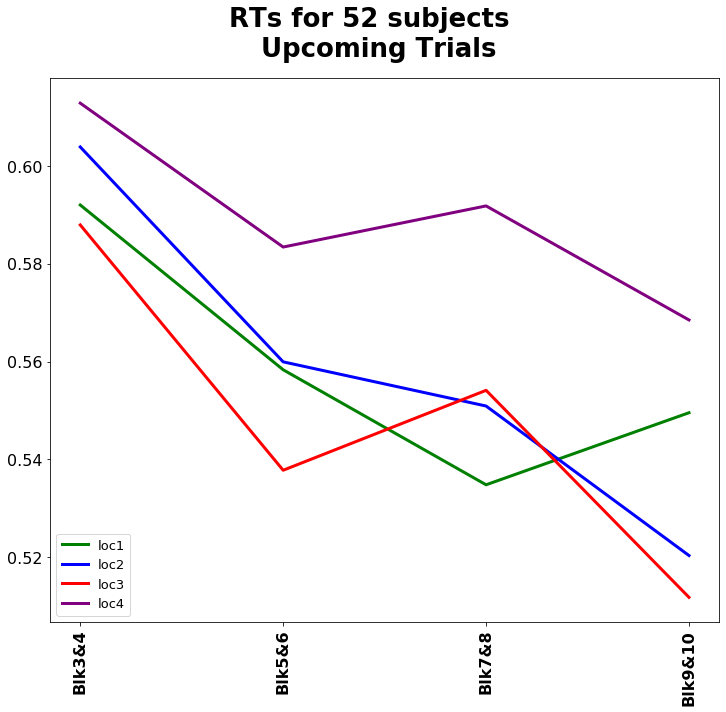

In [125]:

#--------------------------
data_SxGxB = RTs_all_subjs_SxGxB.copy()
data_GxB = np.mean(data_SxGxB.copy(), axis=0)
data_GxAvgB = np.zeros([4,4])

data_GxAvgB[:,0] = np.mean(data_GxB[:,0:2], axis=1)
data_GxAvgB[:,1] = np.mean(data_GxB[:,2:4], axis=1)
data_GxAvgB[:,2] = np.mean(data_GxB[:,4:6], axis=1)
data_GxAvgB[:,3] = np.mean(data_GxB[:,6:8], axis=1)

tot_num_subjects = data_SxGxB.shape[0]
if args.mtdt_feat=='Trgt_Loc_main':        
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
else:
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


font=set_fonts()
fig, ax = plt.subplots(1,1,figsize=(12,10))
lw1=3 ;lw2=4; fwl=13
fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
colors = ['green', 'blue', 'red', 'purple']
xx=range(data_GxAvgB.shape[1])

for ii in range(data_SxGxB.shape[1]):
    ax.plot(xx, data_GxAvgB[ii,:], linewidth=lw1, color=colors[ii])

labels=['Blk3&4', 'Blk5&6', 'Blk7&8', 'Blk9&10']
plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)




In [132]:
def label_diff(i,j,text,X,Y):
        x = (X[i]+X[j])/2
        y = max(Y[i], Y[j])  #1.1*max(Y[i], Y[j])
        dx = abs(X[i]-X[j])
    #     props = {'connectionstyle':'bar','arrowstyle':'-',\
    #                  'shrinkA':20,'shrinkB':20,'linewidth':2}
        ax.annotate(text, xy=(x,y), zorder=10, color='red', fontsize=20)
        ax.annotate('', xy=(X[i],y), xytext=(X[j],y))#, arrowprops=props)

    

../../../results/RTs/eCortex/


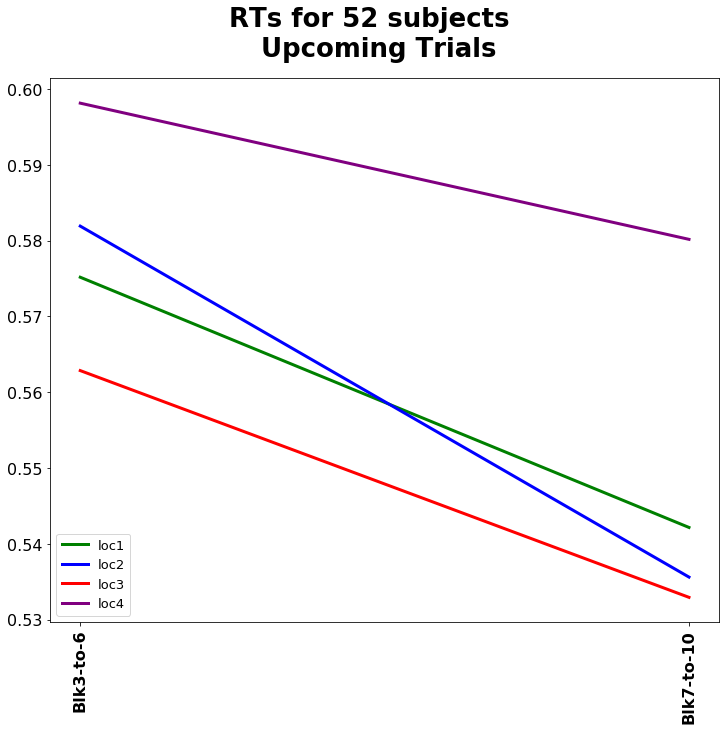

In [126]:
import pickle

args = arguments('early', 'removeevoked', 'False', 'Trgt_Loc_main', 'True' )
args.SAVE_RESULT_ROOT = '../../../results/RTs/eCortex/'
fn_str = args.SAVE_RESULT_ROOT + 'RTs_all_subjs_SxGxB_%s.npy' %(args.mtdt_feat) 

with open(fn_str, 'rb') as f:
    RTs_all_subjs_SxGxB = pickle.load(f)
    
#----------------------------------------------------------------------------------    
# data_SxGxB = RTs_all_subjs_SxGxB.copy()
# data_GxB = np.mean(data_SxGxB.copy(), axis=0)

# tot_num_subjects = data_SxGxB.shape[0]
# if args.mtdt_feat=='Trgt_Loc_main':        
#     title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
# else:
#     title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


# font=set_fonts()
# fig, ax = plt.subplots(1,1,figsize=(12,10))
# lw1=3 ;lw2=4; fwl=13
# fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
# colors = ['green', 'blue', 'red', 'purple']
# xx=range(data_SxGxB.shape[2])

# for ii in range(data_SxGxB.shape[1]):
#     ax.plot(xx, data_GxB[ii,:], linewidth=lw1, color=colors[ii])

# labels=['Blk3', 'Blk4', 'Blk5', 'Blk6', 'Blk7', 'Blk8', 'Blk9', 'Blk10']
# plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
# ax.yaxis.set_tick_params(labelsize=16)

# ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)


#----------------------------------------------------------------------------------
# data_SxGxB = RTs_all_subjs_SxGxB.copy()
# data_GxB = np.mean(data_SxGxB.copy(), axis=0)
# data_GxAvgB = np.zeros([4,4])

# data_GxAvgB[:,0] = np.mean(data_GxB[:,0:2], axis=1)
# data_GxAvgB[:,1] = np.mean(data_GxB[:,2:4], axis=1)
# data_GxAvgB[:,2] = np.mean(data_GxB[:,4:6], axis=1)
# data_GxAvgB[:,3] = np.mean(data_GxB[:,6:8], axis=1)

# tot_num_subjects = data_SxGxB.shape[0]
# if args.mtdt_feat=='Trgt_Loc_main':        
#     title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
# else:
#     title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


# font=set_fonts()
# fig, ax = plt.subplots(1,1,figsize=(12,10))
# lw1=3 ;lw2=4; fwl=13
# fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
# colors = ['green', 'blue', 'red', 'purple']
# xx=range(data_GxAvgB.shape[1])

# for ii in range(data_SxGxB.shape[1]):
#     ax.plot(xx, data_GxAvgB[ii,:], linewidth=lw1, color=colors[ii])

# labels=['Blk3&4', 'Blk5&6', 'Blk7&8', 'Blk9&10']
# plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
# ax.yaxis.set_tick_params(labelsize=16)

# ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)



#----------------------------------------------------------------------------------
RTs_all_subjs_SxGxB
se_GxAvgB

data_SxGxB = RTs_all_subjs_SxGxB.copy()
data_GxB = np.mean(data_SxGxB.copy(), axis=0)
data_GxAvgB = np.zeros([4,2])

data_GxAvgB[:,0] = np.mean(data_GxB[:,0:4], axis=1)
data_GxAvgB[:,1] = np.mean(data_GxB[:,4:8], axis=1)
#--------
statG1 = data_SxGxB[:,:,0:4]
statG2 = data_SxGxB[:,:,4:8]
ps, ts = calc_pvals(statG1, statG2)
#--------
# menMeans   = np.array([596.87988182, 526.07071713]) 
# menStd     = np.array([28.52566264, 21.95989351])
menMeans   = data_GxAvgB[0,:]
menStd     = se_GxAvgB[0,:]

#--------

tot_num_subjects = data_SxGxB.shape[0]
if args.mtdt_feat=='Trgt_Loc_main':        
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
else:
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


font=set_fonts()
fig, ax = plt.subplots(1,1,figsize=(12,10))
lw1=3 ;lw2=4; fwl=13
fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
colors = ['green', 'blue', 'red', 'purple']
xx=range(data_GxAvgB.shape[1])

for ii in range(data_SxGxB.shape[1]): 
    ax.plot(xx, data_GxAvgB[ii,:], yerr=se_GxAvgB[ii,:], linewidth=lw1, color=colors[ii])
    if pval < 0.05:
            label_diff(0,1,'*',xx, data_GxAvgB[ii,:])

plt.ylim(ymax=900)
labels=['Blk3-to-6', 'Blk7-to-10']
plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)


../../../results/RTs/eCortex/


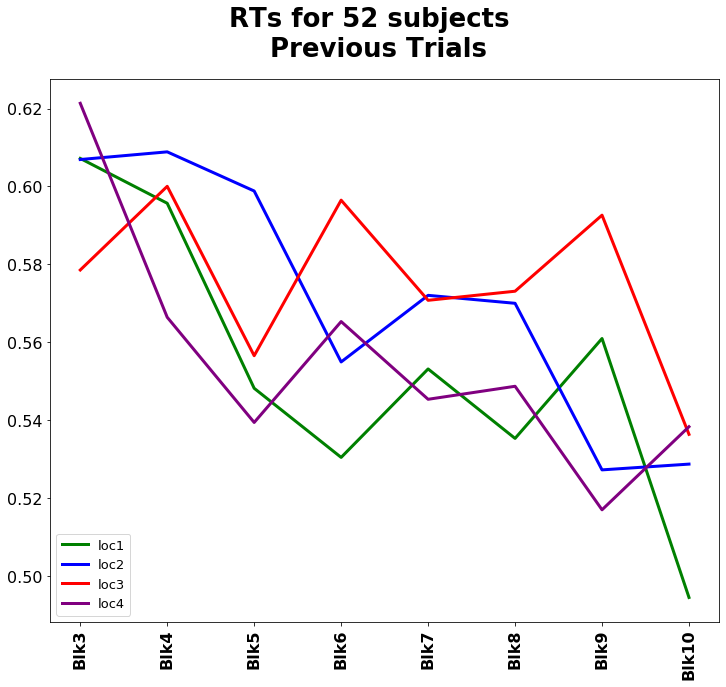

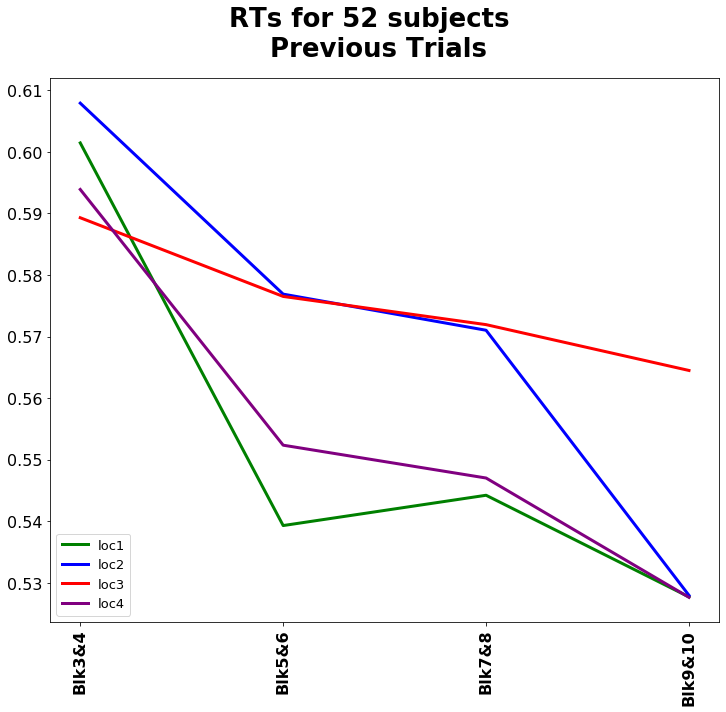

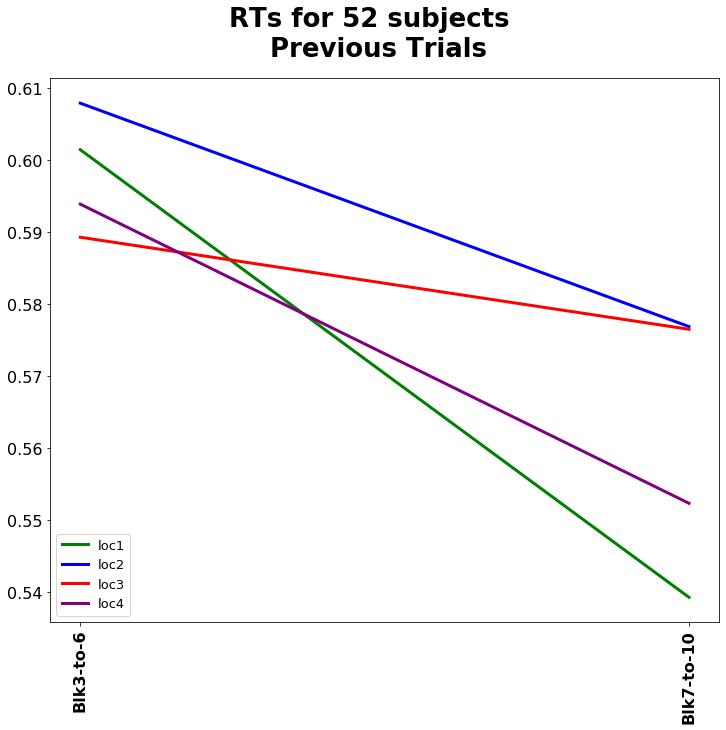

In [21]:
import pickle

args = arguments('early', 'removeevoked', 'False', 'Trgt_Loc_prev', 'True' )
args.SAVE_RESULT_ROOT = '../../../results/RTs/eCortex/'
fn_str = args.SAVE_RESULT_ROOT + 'RTs_all_subjs_SxGxB_%s.npy' %(args.mtdt_feat) 

with open(fn_str, 'rb') as f:
    RTs_all_subjs_SxGxB = pickle.load(f)

#----------------------------------------------------------------------------------    
data_SxGxB = RTs_all_subjs_SxGxB.copy()
data_GxB = np.mean(data_SxGxB.copy(), axis=0)

tot_num_subjects = data_SxGxB.shape[0]
if args.mtdt_feat=='Trgt_Loc_main':        
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
else:
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


font=set_fonts()
fig, ax = plt.subplots(1,1,figsize=(12,10))
lw1=3 ;lw2=4; fwl=13
fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
colors = ['green', 'blue', 'red', 'purple']
xx=range(data_SxGxB.shape[2])

for ii in range(data_SxGxB.shape[1]):
    ax.plot(xx, data_GxB[ii,:], linewidth=lw1, color=colors[ii])

labels=['Blk3', 'Blk4', 'Blk5', 'Blk6', 'Blk7', 'Blk8', 'Blk9', 'Blk10']
plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)


#----------------------------------------------------------------------------------
data_SxGxB = RTs_all_subjs_SxGxB.copy()
data_GxB = np.mean(data_SxGxB.copy(), axis=0)
data_GxAvgB = np.zeros([4,4])

data_GxAvgB[:,0] = np.mean(data_GxB[:,0:2], axis=1)
data_GxAvgB[:,1] = np.mean(data_GxB[:,2:4], axis=1)
data_GxAvgB[:,2] = np.mean(data_GxB[:,4:6], axis=1)
data_GxAvgB[:,3] = np.mean(data_GxB[:,6:8], axis=1)

tot_num_subjects = data_SxGxB.shape[0]
if args.mtdt_feat=='Trgt_Loc_main':        
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
else:
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


font=set_fonts()
fig, ax = plt.subplots(1,1,figsize=(12,10))
lw1=3 ;lw2=4; fwl=13
fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
colors = ['green', 'blue', 'red', 'purple']
xx=range(data_GxAvgB.shape[1])

for ii in range(data_SxGxB.shape[1]):
    ax.plot(xx, data_GxAvgB[ii,:], linewidth=lw1, color=colors[ii])

labels=['Blk3&4', 'Blk5&6', 'Blk7&8', 'Blk9&10']
plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)
#----------------------------------------------------------------------------------
data_SxGxB = RTs_all_subjs_SxGxB.copy()
data_GxB = np.mean(data_SxGxB.copy(), axis=0)
data_GxAvgB = np.zeros([4,2])

data_GxAvgB[:,0] = np.mean(data_GxB[:,0:4], axis=1)
data_GxAvgB[:,1] = np.mean(data_GxB[:,4:8], axis=1)

tot_num_subjects = data_SxGxB.shape[0]
if args.mtdt_feat=='Trgt_Loc_main':        
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Upcoming Trials')
else:
    title = 'RTs for %s subjects \n %s' %(tot_num_subjects, 'Previous Trials')


font=set_fonts()
fig, ax = plt.subplots(1,1,figsize=(12,10))
lw1=3 ;lw2=4; fwl=13
fig.suptitle(title, fontproperties=font, fontsize=26, fontweight='bold')
colors = ['green', 'blue', 'red', 'purple']
xx=range(data_GxAvgB.shape[1])

for ii in range(data_SxGxB.shape[1]):
    ax.plot(xx, data_GxAvgB[ii,:], linewidth=lw1, color=colors[ii])

labels=['Blk3-to-6', 'Blk7-to-10']
plt.xticks(xx, labels, rotation='vertical', fontproperties=font, fontsize=16, fontweight='bold')
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(['loc1', 'loc2', 'loc3', 'loc4'], loc='lower left', fontsize=fwl)